# Clasificación de espectros estelares en LAMOST

In [48]:
from TheCannon.lamost import load_spectra
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_style('white')
plt.rcParams['figure.figsize'] = (15, 10)
from glob import glob
import re
import numpy as np
import pandas as pd
from joblib import load, dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
import xlsxwriter

In [294]:
wl1, flux1, ivar1 = load_spectra('data/LAMOST/A0/spec-55903-B90304_sp05-122.fits')
wl2, flux2, ivar2 = load_spectra('data/LAMOST/A0/spec-55909-B90903_1_sp04-010.fits')

Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded


In [295]:
df_test = pd.DataFrame({'wavelength':wl1, 'flux':flux1})#.to_excel('ejemplo_wavelengths.xlsx', index_label='N', engine = 'xlsxwriter')
df_test.set_index('wavelength', inplace = True)

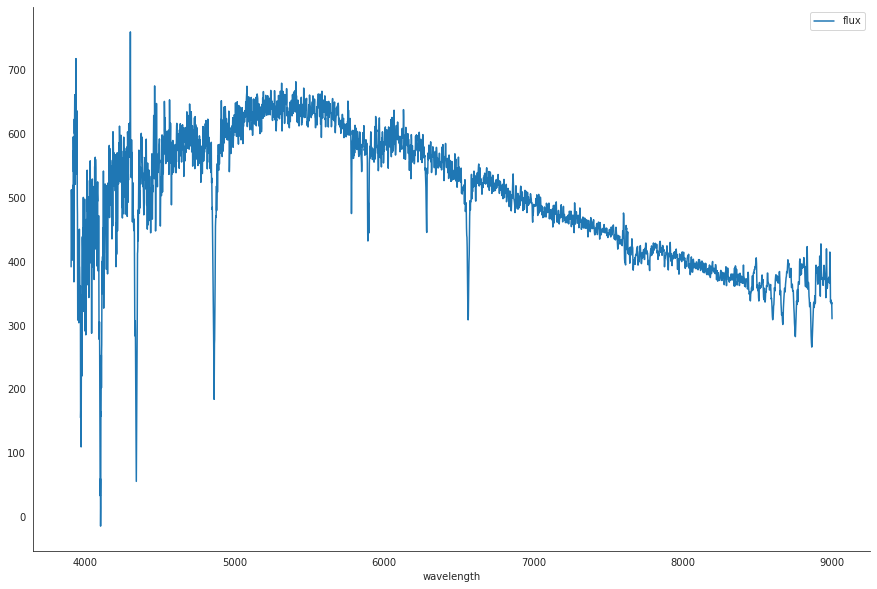

In [301]:
#fig, _ = plt.subplots(figsize = (15,10))
df_test.plot()
sn.despine()

TypeError: plot got an unexpected keyword argument 'x'

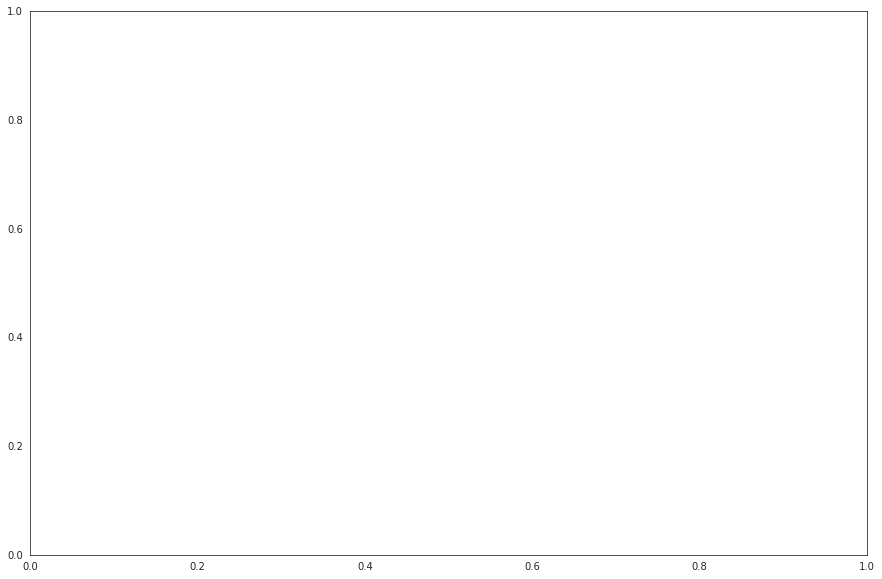

In [290]:
fig, _ = plt.subplots(figsize = (15,10))
plt.plot(x = wl1, y = flux1)
sn.despine()

In [4]:
len(flux2)

3626

- COnsiderar cortar en wl 7000 o similar 
- considerar una capa de atencion para explorar en que partes del espectro se fija el modelo para hacer la clasificacion
- COnsiderar poner un umbral en cuanto a flujo para el rango de 1000-1500, es la mediana menor a x valor? --> desechar producto de la baja intensidad de la estrella. 
- Separar las clases en macro-grupos: A0-A4 y A5-A9 etc. para facilitar en una primera instancia la clasificación.

In [2]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [3]:
def stack_spectra(base_path):
    get_subclass = re.compile('data/LAMOST/(.*)/.*.fits$')
    file_list = glob(f'{base_path}/*.fits')
    #stacked_spectra = np.array(load_spectra(file_list[0])[1])
    to_stacklist = []
    clases = []
    n_elementos = 0
    for path in file_list:
        try:
            spectra = np.array(load_spectra(path)[1])
            if len(spectra) != 3626:
                print(f'Problema con archivo {path}. Continuando sin este...')
                continue
            else:
                to_stacklist.append(spectra)
                n_elementos +=1
                #clases.append(get_subclass.findall(path)[0])
        except:
            print(f'Problema con archivo {path}. Continuando sin este...')
            continue
    stacked_spectra = np.vstack(to_stacklist)
    return n_elementos, stacked_spectra

In [15]:
get_subclass = re.compile('data/LAMOST/(.*)/.*.fits$')
clases_diferentes = set([get_subclass.findall(path)[0] for path in glob('data/LAMOST/*/*.fits')])

In [8]:
%%time
unstacked_spectra = {clase:stack_spectra(f'data/LAMOST/{clase}') for clase in list(clases_diferentes)}

Loading spectra...
Spectra loaded
Loading spectra...
Problema con archivo data/LAMOST/G8/spec-55859-F5907_sp12-201.fits. Continuando sin este...
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loading spectra...
Spectra loaded
Loadi

KeyboardInterrupt: 

In [16]:
Y = np.array(flatten([[f'{class_name}']*x[0] for class_name, x in unstacked_spectra.items()]))
X = np.vstack(flatten([x[1] for _, x in unstacked_spectra.items()]))

NameError: name 'unstacked_spectra' is not defined

In [152]:
#dump(unstacked_spectra, 'data/stacked_classes/unstacked_sectra.npy')
#dump(X, 'data/stacked_classes/stacked_X.npy')
#dump(Y, 'data/stacked_classes/stacked_Y.npy')
#dump([get_subclass.findall(path)[0] for path in glob('data/LAMOST/*/*.fits')], 'data/LAMOST/stacked_classes/clases.npy')

In [4]:
X = load('data/stacked_classes/stacked_X.npy')
Y = load('data/stacked_classes/stacked_Y.npy')

In [5]:
Y = np.array(pd.Series(Y).replace({'A0': 'A', 'A1IV':'A', 'A2IV':'A', 'A3IV': 'A', 'A6IV':'A', 'A7III':'A', 'A8III':'A', 'A9V':'A', 'A5': 'A',
                      'B9': 'B',
                      'F4':'F', 'F8':'F','F2': 'F', 'F6': 'F',
                      'G0':'G', 'G2':'G', 'G4': 'G', 'G8':'G',
                      'K2': 'K', 'K4':'K', 'K7':'K', 'K0':'K', 'K9': 'K',
                      'M0':'M', 'M8':'M', 'M2':'M', 'M4': 'M'}))

In [302]:
X.shape

(22350, 3626)

In [274]:
df = pd.DataFrame(X)
df['Y'] = Y

In [275]:
df = df[df['Y'].isin(['A', 'B', 'F', 'G', 'K', 'M'])]

In [276]:
print('Frecuencia de clases en el dataset obtenido:')
print(df.Y.value_counts())

Frecuencia de clases en el dataset obtenido:
A    6512
F    4328
K    4049
G    3119
M    2971
B     957
Name: Y, dtype: int64


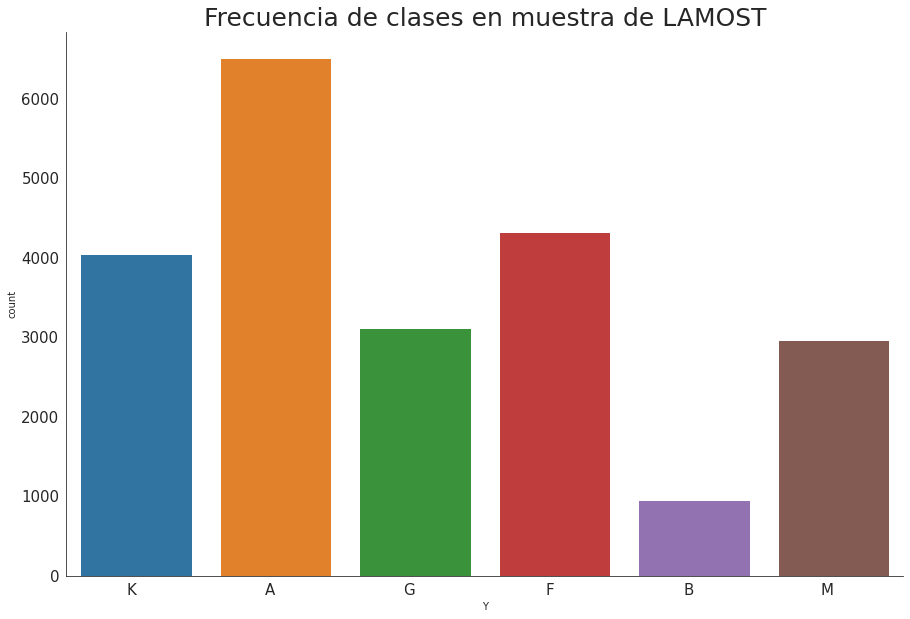

In [289]:
sn.countplot(df['Y'])
plt.title('Frecuencia de clases en muestra de LAMOST', fontsize = 25)
plt.xticks(fontsize = 15, ha = 'right')
plt.yticks(fontsize = 15)
sn.despine();

In [9]:
#X = np.vstack([x[1] for x in a.values()])
#Y = np.array(flatten([[x[0]]*x[1][0] for x in list(a.items())]))

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns = 'Y'), df['Y'], random_state = 15051991, test_size = 0.3)

NO

In [12]:
rf_grid = {'n_estimators': range(200, 1500, 500), 'max_depth':range(20, 100, 40)}
knn_grid = {'n_neighbors': range(5, 40, 5), 'weights':['uniform', 'distance']}
xgboost_grid = {'n_estimators': range(100, 1500, 500), 'max_depth':range(20, 100, 40), 'learning_rate': [0.001, 0.1, 0.5]}

#### Random Forests

----------------------------------------------------

In [14]:
#  model  RF
rf = RandomForestClassifier(random_state = 1)# Train
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

In [15]:
predictions_rf = rf.predict(x_test)

In [16]:
from joblib import load, dump
dump(rf, 'rf.joblib')

['rf.joblib']

In [17]:
predictions_rf

array(['F', 'M', 'G', ..., 'M', 'F', 'K'], dtype=object)

-------------------------------------------------------

In [9]:
%%time
rf_gridsearch = GridSearchCV(RandomForestClassifier(n_jobs = -1), rf_grid)
rf_gridsearch.fit(x_train, y_train)

NameError: name 'rf_grid' is not defined

In [16]:
rf_preds_test = rf_gridsearch.best_estimator_.predict(x_test)

#### XGBoost

-------------------------------------

In [18]:
#  model  XGBOOST
xgboost = XGBClassifier(random_state = 1)# Train
xgboost.fit(x_train, y_train)

[00:16:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [19]:
predictions_xgboost = xgboost.predict(x_test)

In [20]:
dump(xgboost, 'xgboost.joblib')

['xgboost.joblib']

In [21]:
predictions_xgboost

array(['F', 'M', 'G', ..., 'M', 'F', 'K'], dtype=object)

-------------------------------

In [17]:
%%time
xgboost_gridseach = GridSearchCV(XGBClassifier(n_jobs = -1), xgboost_grid)
xgboost_gridseach.fit(x_train, y_train)

[01:54:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:31:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:07:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:44:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

KeyboardInterrupt: 

In [18]:
xgboost_preds = xgboost_gridseach.best_estimator_.predict(x_test)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

#### KNN

-----------------------

In [33]:
#  model  KNN
knn = KNeighborsClassifier()# Train
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [23]:
predictions_knn = knn.predict(x_test)

NameError: name 'knn' is not defined

In [22]:
predictions_knn

NameError: name 'predictions_knn' is not defined

-------------------------

In [24]:
%%time
knn_gridsearch = GridSearchCV(KNeighborsClassifier(n_jobs = -1), knn_grid)
knn_gridsearch.fit(x_train, y_train)

CPU times: user 1h 20s, sys: 54min 26s, total: 1h 54min 47s
Wall time: 10min 41s


GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-1),
             param_grid={'n_neighbors': range(5, 40, 5),
                         'weights': ['uniform', 'distance']})

In [25]:
knn_preds = knn_gridsearch.best_estimator_.predict(x_test)

In [26]:
dump(knn_gridsearch.best_estimator_, 'knn.joblib')

['knn.joblib']

---------------------------

#### Predicciones

In [27]:
print('############## RandomForest ##############')
print(classification_report(y_test, predictions_rf))

############## RandomForest ##############
              precision    recall  f1-score   support

           A       0.83      0.91      0.87      1935
           B       0.61      0.26      0.36       317
           F       0.72      0.79      0.75      1312
           G       0.73      0.54      0.62       921
           K       0.82      0.90      0.86      1201
           M       0.91      0.89      0.90       895

    accuracy                           0.80      6581
   macro avg       0.77      0.71      0.73      6581
weighted avg       0.79      0.80      0.79      6581



In [30]:
print('############## KNN ##############')
print(classification_report(y_test, knn_preds))

############## KNN ##############
              precision    recall  f1-score   support

           A       0.77      0.87      0.82      1935
           B       0.59      0.34      0.43       317
           F       0.64      0.68      0.66      1312
           G       0.56      0.51      0.53       921
           K       0.83      0.77      0.80      1201
           M       0.93      0.86      0.89       895

    accuracy                           0.74      6581
   macro avg       0.72      0.67      0.69      6581
weighted avg       0.74      0.74      0.73      6581



In [29]:
print('############## XGBoost ##############')
print(classification_report(y_test, predictions_xgboost))

############## XGBoost ##############
              precision    recall  f1-score   support

           A       0.86      0.92      0.89      1935
           B       0.60      0.29      0.39       317
           F       0.77      0.84      0.80      1312
           G       0.78      0.66      0.72       921
           K       0.85      0.91      0.88      1201
           M       0.93      0.90      0.92       895

    accuracy                           0.83      6581
   macro avg       0.80      0.75      0.77      6581
weighted avg       0.83      0.83      0.82      6581



----------------------------------------------------------

FEATURE IMPORTANCES MEJOR MODELO : XGBOOST

In [153]:
importances  = pd.read_excel('ejemplo_wavelengths.xlsx')
importances['Importance'] = xgboost.feature_importances_
importances.drop(columns = ['N'], inplace = True)
importances.set_index('wavelength', inplace = True)

In [246]:
importances['importance_category'] = np.where(importances.Importance >= importances.Importance.quantile(.75), 1, 0)

In [247]:
importances.importance_category.value_counts()

0    2719
1     907
Name: importance_category, dtype: int64

In [248]:
from copy import copy
importances_0 = copy(importances)
importances_1 = copy(importances)

In [249]:
importances_0['flux'] = importances_0.apply(lambda x: np.nan if x['importance_category'] == 1 else x['flux'], axis = 1)
importances_1['flux'] = importances_1.apply(lambda x: np.nan if x['importance_category'] == 0 else x['flux'], axis = 1)

In [250]:
points = np.array([importances.index, importances['flux']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

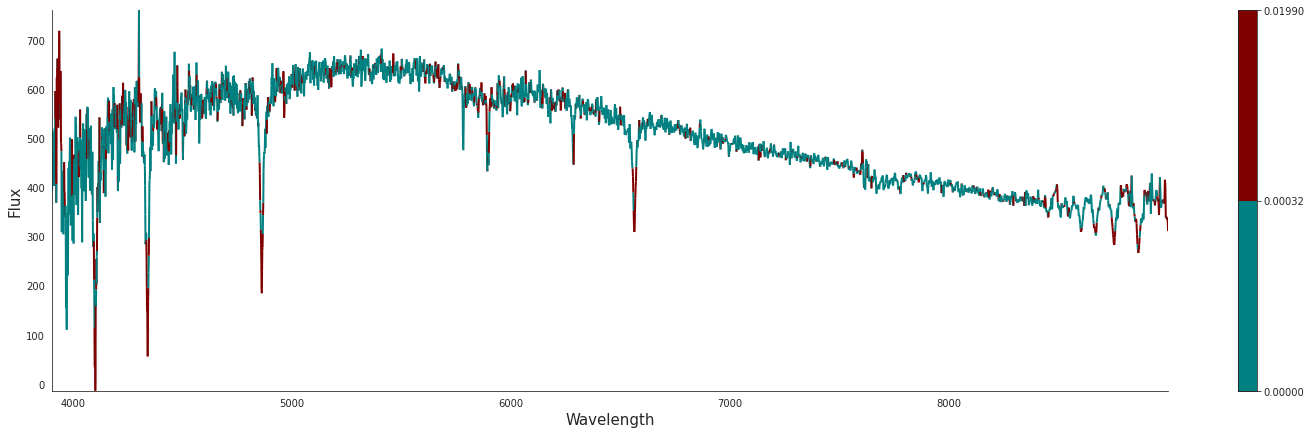

In [311]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
# Use a boundary norm instead

fig, axs = plt.subplots(figsize = (25, 7))
cmap = ListedColormap(['teal', 'maroon'])
norm = BoundaryNorm([importances.Importance.min(), importances.Importance.quantile(.80), importances.Importance.max()], cmap.N)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(importances.Importance)
lc.set_linewidth(2)
line = axs.add_collection(lc)
fig.colorbar(line, ax=axs)

axs.set_xlim(importances.index.min(), importances.index.max())
axs.set_ylim(importances.flux.min(), importances.flux.max())
sn.despine()
plt.xlabel('Wavelength', fontsize =15)
plt.ylabel('Flux', fontsize =15)
plt.show()

In [283]:
df_subset = pd.DataFrame(X)
df_subset['y'] = Y
df_subset = df_subset[df_subset['y'].isin(['A', 'B', 'F', 'G', 'K', 'M'])]

In [284]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_subset.drop(columns = 'y'))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 21936 samples in 0.054s...
[t-SNE] Computed neighbors for 21936 samples in 42.778s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21936
[t-SNE] Computed conditional probabilities for sample 2000 / 21936
[t-SNE] Computed conditional probabilities for sample 3000 / 21936
[t-SNE] Computed conditional probabilities for sample 4000 / 21936
[t-SNE] Computed conditional probabilities for sample 5000 / 21936
[t-SNE] Computed conditional probabilities for sample 6000 / 21936
[t-SNE] Computed conditional probabilities for sample 7000 / 21936
[t-SNE] Computed conditional probabilities for sample 8000 / 21936
[t-SNE] Computed conditional probabilities for sample 9000 / 21936
[t-SNE] Computed conditional probabilities for sample 10000 / 21936
[t-SNE] Computed conditional probabilities for sample 11000 / 21936
[t-SNE] Computed conditional probabilities for sample 12000 / 21936
[t-SNE] Computed conditional probabilities for s

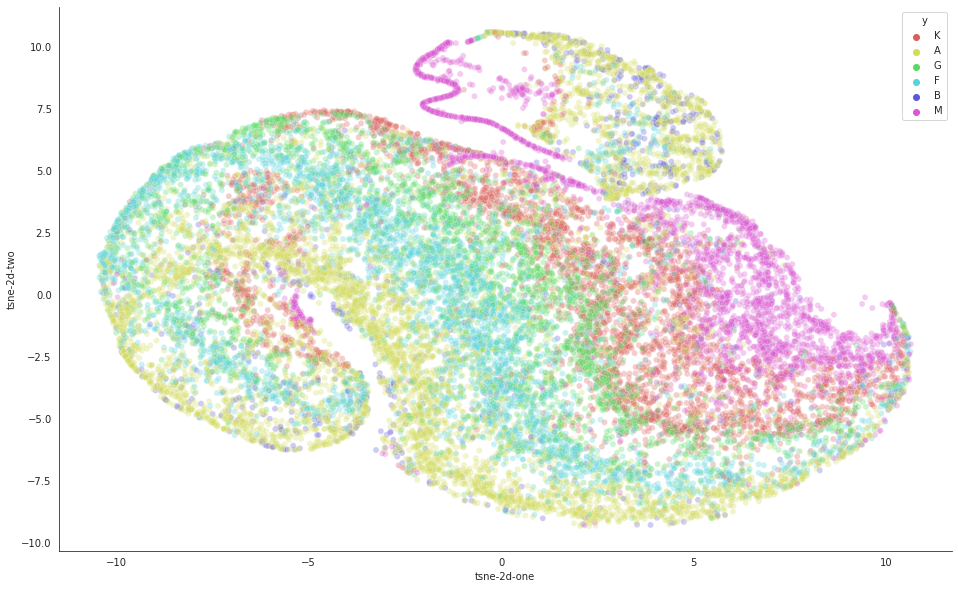

In [312]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sn.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sn.color_palette("hls", len(df_subset.y.unique())),
    data=df_subset,
    legend="full",
    alpha=0.3
)
sn.despine()

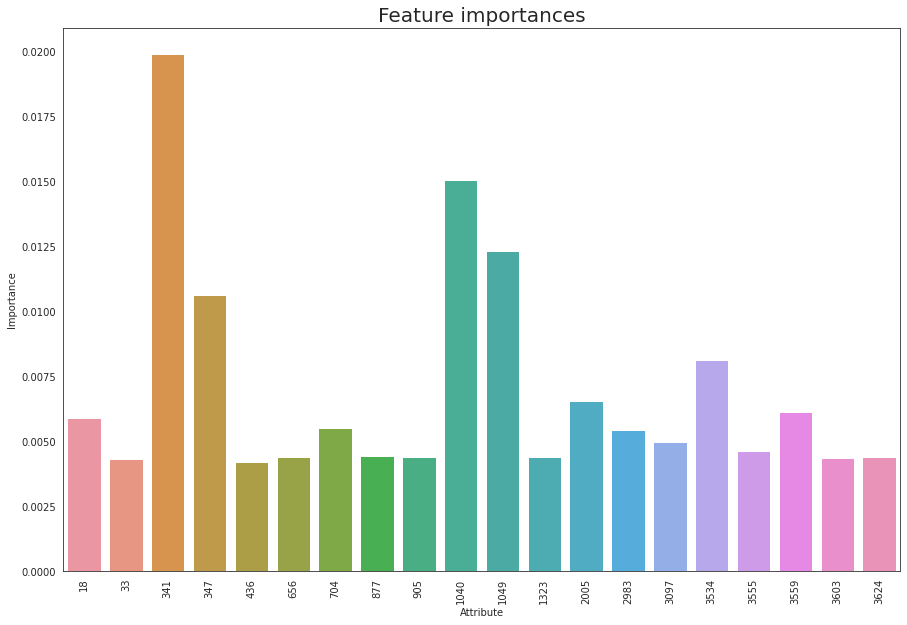

<Figure size 1080x720 with 0 Axes>

In [101]:
fig, _ = plt.subplots(figsize = (15,10))
fig = sn.barplot(x='Attribute', y = 'Importance', data = importances_top30)
plt.title('Feature importances', size=20)
plt.xticks(rotation='vertical')
plt.show()
plt.savefig('importancias.jpg')

In [96]:
importances = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': xgboost.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

Feature: 0, Score: 0.00018
Feature: 1, Score: 0.00016
Feature: 2, Score: 0.00019
Feature: 3, Score: 0.00022
Feature: 4, Score: 0.00009
Feature: 5, Score: 0.00008
Feature: 6, Score: 0.00022
Feature: 7, Score: 0.00022
Feature: 8, Score: 0.00018
Feature: 9, Score: 0.00024
Feature: 10, Score: 0.00015
Feature: 11, Score: 0.00011
Feature: 12, Score: 0.00018
Feature: 13, Score: 0.00017
Feature: 14, Score: 0.00018
Feature: 15, Score: 0.00014
Feature: 16, Score: 0.00037
Feature: 17, Score: 0.00038
Feature: 18, Score: 0.00590
Feature: 19, Score: 0.00045
Feature: 20, Score: 0.00419
Feature: 21, Score: 0.00024
Feature: 22, Score: 0.00033
Feature: 23, Score: 0.00038
Feature: 24, Score: 0.00033
Feature: 25, Score: 0.00066
Feature: 26, Score: 0.00030
Feature: 27, Score: 0.00064
Feature: 28, Score: 0.00111
Feature: 29, Score: 0.00106
Feature: 30, Score: 0.00101
Feature: 31, Score: 0.00225
Feature: 32, Score: 0.00253
Feature: 33, Score: 0.00433
Feature: 34, Score: 0.00088
Feature: 35, Score: 0.00274
Fe

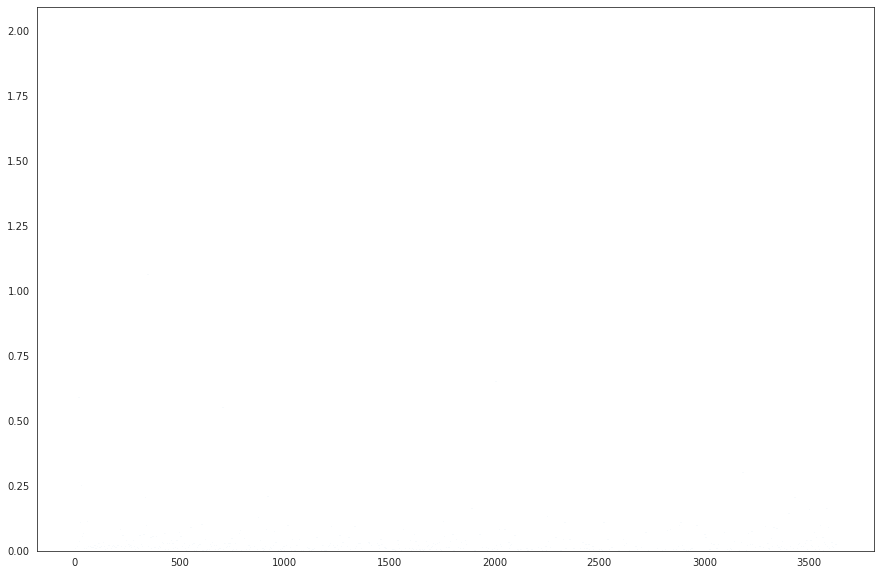

In [73]:
# get importance
importance = xgboost.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance*100)
pyplot.show()

# Good Ol' linear layer

In [1]:
from torch import nn
import torch

In [5]:
nn.Conv2D

AttributeError: module 'torch.nn' has no attribute 'Conv2D'

In [11]:
modules = []
modules.append(nn.Linear(X.shape[1], len(np.unique(Y))))
modules.append(nn.Softmax(dim = 1))

model = nn.Sequential(*modules)

AttributeError: module 'torch.nn' has no attribute 'Linear'

In [190]:
x = torch.tensor(X[:64])

In [191]:
x.size()

torch.Size([64, 3626])

In [192]:
y = model(x)

In [193]:
y.size()

torch.Size([64, 10])

In [194]:
y

tensor([[3.8527e-20, 8.5556e-17, 4.0493e-04, 3.3738e-13, 1.0534e-08, 6.7496e-10,
         9.9959e-01, 1.4882e-07, 8.9104e-12, 2.4894e-07],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 4.2812e-34, 1.0025e-14, 5.0373e-33, 1.1127e-13, 7.2622e-21,
         1.0000e+00, 9.4959e-21, 6.7603e-27, 8.0637e-26],
        [2.3066e-35, 2.8942e-25, 2.2930e-09, 3.1611e-22, 7.9033e-08, 2.5868e-16,
         1.0000e+00, 1.4197e-14, 2.3914e-22, 1.9220e-15],
        [1.7878e-12, 4.2562e-08, 1.3496e-04, 8.0387e-11, 3.8814e-03, 6.1949e-06,
         9.9596e-01, 1.6468e-05, 1.8952e-08, 4.7897e-07],
        [1.5295e-17, 5.7741e-14, 5.5452e-05, 5.9931e-13, 8.9550e-06, 4.1327e-08,
         9.9994e-01, 1.6799e-07, 1.3249e-08, 5.5362e-08],
        [1.5465e-41, 6.3438e-28, 5.6085e-11, 2.5072e-28, 5.4729e-13, 6.4454e-21,
         1.0000e+00, 2.8569e-15, 6.7933e-22, 2.4792e-21],
        [5.4439e-24, 5.2636

In [ ]:
s